# Investigating Hybrid Strategies for Systematic Literature Review

In [51]:
%matplotlib inline

import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import database
from snowballing.operations import reload, work_by_varname, load_work_map_all_years
from snowballing.strategies import Strategy, State
import custom_strategies
from functools import reduce
from matplotlib_venn import venn2, venn2_circles
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

custom_strategies.LIMIT_YEAR = 2019
reload()
# !pip install matplotlib-venn

In [110]:
import statistics as s
from collections import Counter, deque
from snowballing.operations import metakey, metakey_title

def busca(*libraries, seed=None, filter_function=None):
    filter_function = filter_function or (lambda x: x.category in ("snowball",))
    if seed is not None:
        iterable = ((1, work_by_varname(x)) for x in seed)
    else:
        iterable = load_work_map_all_years()
    seedset = set()
    visited = set()
    for _, work in iterable:
        for library in libraries:
            if int(getattr(work, library, 0)):
                visited.add(work)
                if filter_function(work):
                    seedset.add(work)
                break
    return seedset, filter_function, visited

def descreve_delta(strategy, state, name):
    target = state.find(name)
    previous_related = reduce(lambda x, y: x | y, (s.related for s in target.previous[0]), set())
    for work in previous_related:
        backward = set(strategy.ref[work]) & target.delta_visited
        if backward:
            print('backward', work.metakey)
            for ref in backward:
                print('-', ref.metakey, 'related' if ref in target.delta_related else '')
        forward = set(strategy.rev_ref[work]) & target.delta_visited
        if forward:
            print('forward', work.metakey)
            for ref in forward:
                print('-', ref.metakey, 'related' if ref in target.delta_related else '')

def separa_backward_forward(state):
    backward = set()
    forward = set()
    stack = [state]
    visited = {id(state)}
    while stack:
        current = stack.pop()
        if current.previous:
            if current.previous[1] == "backward":
                backward |= current.delta_related
            if current.previous[1] == "forward":
                forward |= current.delta_related
                
            antecessors = current.previous[0]
            for previous in antecessors:
                if id(previous) not in visited:
                    visited.add(id(previous))
                    stack.append(previous)
    return backward, forward

def encontraria(strategy, state):
    backward = set()
    forward = set()
    related = state.related - state.find("s0").related
    for work in state.related:
        backward |= (set(strategy.ref[work]) & related)
        forward |= (set(strategy.rev_ref[work]) & related)
    return backward, forward

class FinalSelection(State):
    
    def __init__(self, state):
        self.state = state
    
    @property
    def log(self):
        return []
    
    @property
    def dot(self):
        result = ["digraph G {", '  rankdir="RL";', ""]
        actions = Counter()

        stack = deque([self.state])
        visited = {id(self.state)}
        while stack:
            current = stack.popleft()
            current.final_selected = {
                work for work in current.related 
                if int(getattr(work, "final_selected", 0))
            }
            current.seed_set = {
                work for work in current.related 
                if int(getattr(work, "seed_set", 0))
            }
            current.delta_selected = {}
            current.delta_seed_set = {}
            options = [
                (" visited", len(current.visited)),
                (" selected", len(current.related)),  #  ("WorkSnowball", len(current.related)),
                #("selected", len(current.final_selected)),
                #("seed_set", len(current.seed_set)),
            ]
            result.append('  {0} [label="{0}\\n{1}"];'.format(
                current.name, 
                "\\n".join("{}: {}".format(key, value) for key, value in options)
            ))
            if current.previous:
                operation = current.previous[1]
                for element in current.previous[0]:
                    if operation == "union":
                        result.append('  {} -> {} [label="{}"];'.format(
                            current.name, element.name, operation
                        ))
                        
                        
                    else:
                        current.delta_selected = {
                            work for work in current.delta_related 
                            if int(getattr(work, "final_selected", 0))
                        }
                        current.delta_seed_set = {
                            work for work in current.delta_related 
                            if int(getattr(work, "seed_set", 0))
                        }
                        
                        options = [
                            (" visited", len(current.delta_visited)),
                            (" selected", len(current.delta_related)),
                            #("selected", len(current.delta_selected)),
                            #("seed_set", len(current.delta_seed_set)),
                        ]
                        result.append('  {} -> {} [label="{}\\n{}"];'.format(
                            current.name, element.name, operation,
                            "\\n".join("{}: {}".format(key, value) for key, value in options)
                        ))
                    if id(element) not in visited:
                        stack.append(element)
                        visited.add(id(element))
            result.append("")

        result.append("}")
        return '\n'.join(result)


def precision_recall(state, total, final, stop=""):
    # Precisao 0 quando nao visita nada
    array = [[
        "state", "precision", "recall", "fmeasure", 
        "final_precision", "final_recall", "final_fmeasure", 
        "operation", "delta_related", "delta_visited", "delta_selected",
        "related", "visited", "final_selected",
        "accumulated_precision", "accumulated_recall", "accumulated_fmeasure",
        "final_accumulated_precision", "final_accumulated_recall", "final_accumulated_fmeasure"
    ]]
    FinalSelection(state).dot
    stack = deque([state])
    visited = {id(state)}
    while stack:
        current = stack.pop()
        accumulated_recall = len(current.related) / len(total)
        recall = len(current.delta_related) / len(total)
        final_accumulated_recall = len(current.final_selected) / len(final)
        final_recall = len(current.delta_selected) / len(final)
        try:
            accumulated_precision = len(current.related) / len(current.visited)
            precision = len(current.delta_related) / len(current.delta_visited)
        except ZeroDivisionError:
            precision = float('nan')
        try:
            final_accumulated_precision = len(current.final_selected) / len(current.visited)
            final_precision = len(current.delta_selected) / len(current.delta_visited)
        except ZeroDivisionError:
            final_precision = float('nan')
        try:
            accumulated_fmeasure = s.harmonic_mean([accumulated_precision, accumulated_recall])
            fmeasure = s.harmonic_mean([precision, recall])
        except ZeroDivisionError:
            fmeasure = float('nan')
        try:
            final_accumulated_fmeasure = s.harmonic_mean([final_accumulated_precision, final_accumulated_recall])
            final_fmeasure = s.harmonic_mean([final_precision, final_recall])
        except ZeroDivisionError:
            final_fmeasure = float('nan')
            
            
        array.append([
            current.name,
            precision,
            recall,
            fmeasure,
            final_precision,
            final_recall,
            final_fmeasure,
            current.previous[1] if current.previous else "-",
            len(current.delta_related),
            len(current.delta_visited),
            len(current.delta_selected),
            len(current.related),
            len(current.visited),
            len(current.final_selected),
            accumulated_precision,
            accumulated_recall,
            accumulated_fmeasure,
            final_accumulated_precision,
            final_accumulated_recall,
            final_accumulated_fmeasure,
        ])
        if current.name == stop:
            break
        if current.previous:              
            antecessors = current.previous[0]
            for previous in antecessors:
                if id(previous) not in visited:
                    visited.add(id(previous))
                    stack.appendleft(previous)
    return array

# Strategies

## Strategy 1 - Database Search

In [111]:
print ("Total de estudos primários reproduzidos: 11 do Seed Set + 3 encontrados durante o Snowballing = ", len ({x for _, x in load_work_map_all_years() if x.category == "snowball"}))

Total de estudos primários reproduzidos: 11 do Seed Set + 3 encontrados durante o Snowballing =  14


In [112]:
reload()
TOTAL = {x for _, x in load_work_map_all_years() if getattr(x, "seed_set", 0)}
FINAL = {x for _, x in load_work_map_all_years() if getattr(x, "final_selected", 0)}
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus2016", filter_function=filter_function)) # busca simples

state = strategy.initial
strategy.initial.visited

FinalSelection(state);

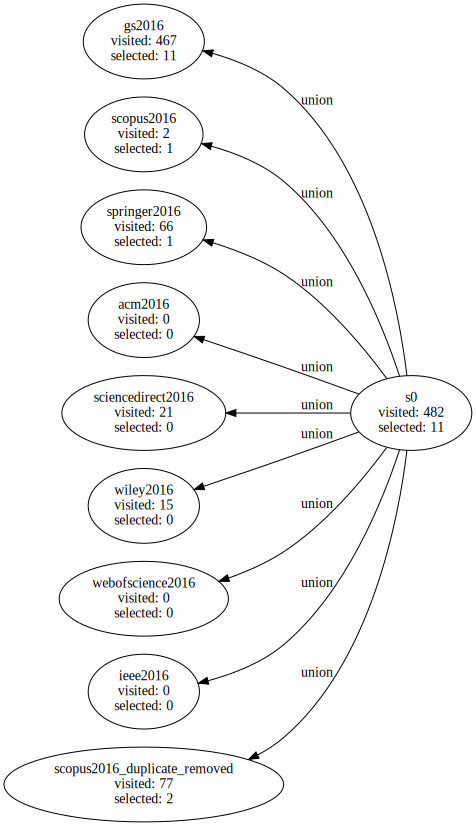

In [113]:
from snowballing.strategies import State

reload()
def busca_completa(libs, filter_function):
    union = None
    for dl in libs:
        strategy = Strategy(*busca(dl, filter_function=filter_function))
        strategy.initial.name = dl
        if union is None:
            union = strategy.initial.derive("union", name="s0") 
        else:
            union.visited.update(strategy.initial.visited)
            union.related.update(strategy.initial.related)
            union.previous[0].append(strategy.initial)

    State.last_id = 0
    strategy.initial = union
    return strategy

strategy = busca_completa(["gs2016", "scopus2016", "springer2016", "acm2016", "sciencedirect2016", "wiley2016", "webofscience2016", "ieee2016", "scopus2016_duplicate_removed"], filter_function)
state = strategy.initial
final = FinalSelection(strategy.initial)
final

In [114]:
def salvar(state, arquivo):
    with open("{}.dot".format(arquivo), "w") as f:
        f.write(state.dot)
    !dot -Tsvg {arquivo}.dot -o {arquivo}.svg
    !inkscape -f {arquivo}.svg -e {arquivo}.png -d 300

In [115]:
salvar(final, "final")

DPI: 300
Background RRGGBBAA: ffffff00
Area 0:0:636:1102,67 exported to 1987 x 3446 pixels (300 dpi)
Bitmap saved as: final.png


In [116]:
#strategy.initial.seed_set @ metakey_title
strategy.initial.related

{Building process definition with ontology background,
 Automated software engineering process assessment: supporting diverse models using an ontology,
 Towards automated process assessment in software engineering,
 A partial formalization of the CMMI-DEV—A capability maturity model for development,
 A strategic test process improvement approach using an ontological description for MND-TMM,
 An ontology based infrastructure to support CMMI-based software process assessment,
 Project assets ontology (PAO) to support gap analysis for organization process improvement based on CMMI v. 1.2,
 Representing Software Process in Description Logics: n Ontology pproach for Software Process Reasoning and Verification,
 A software process ontology and its application,
 An ontology-based approach to express software processes,
 A CMMI Ontology for An Ontology-Based Software Process Assessment Tool}

In [117]:
array = []
name = "E1"
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df = df.round(4)
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

d_decimals = 3    
for coluna in ['precision', 'recall', 'fmeasure', 'final_precision', 'final_recall', 'final_fmeasure','delta_related', 'delta_visited', 'delta_selected','related', 'visited', 'final_selected','accumulated_precision', 'accumulated_recall', 'accumulated_fmeasure','final_accumulated_precision', 'final_accumulated_recall', 'final_accumulated_fmeasure']:
      df[coluna] = df[coluna].apply(lambda x: round(x,d_decimals))

df
                                  


10,state,precision,recall,fmeasure,final_precision,final_recall,final_fmeasure,operation,delta_related,delta_visited,delta_selected,related,visited,final_selected,accumulated_precision,accumulated_recall,accumulated_fmeasure,final_accumulated_precision,final_accumulated_recall,final_accumulated_fmeasure
0,scopus2016_duplicate_removed,0.026,0.182,0.045,0.0,0.0,0,-,2,77,0,2,77,2,0.026,0.182,0.045,0.026,0.143,0.044
1,ieee2016,NaN,0.000,0.000,NaN,0.0,0,-,0,0,0,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000
2,webofscience2016,NaN,0.000,0.000,NaN,0.0,0,-,0,0,0,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000
3,wiley2016,0.000,0.000,0.000,0.0,0.0,0,-,0,15,0,0,15,0,0.000,0.000,0.000,0.000,0.000,0.000
4,sciencedirect2016,0.000,0.000,0.000,0.0,0.0,0,-,0,21,0,0,21,0,0.000,0.000,0.000,0.000,0.000,0.000
5,acm2016,NaN,0.000,0.000,NaN,0.0,0,-,0,0,0,0,0,0,0.015,0.000,0.000,0.015,0.000,0.000
6,springer2016,0.015,0.091,0.026,0.0,0.0,0,-,1,66,0,1,66,1,0.015,0.091,0.026,0.015,0.071,0.025
7,scopus2016,0.500,0.091,0.154,0.0,0.0,0,-,1,2,0,1,2,1,0.500,0.091,0.154,0.500,0.071,0.125
8,gs2016,0.024,1.000,0.046,0.0,0.0,0,-,11,467,0,11,467,11,0.024,1.000,0.046,0.024,0.786,0.046
9,s0,NaN,0.000,0.000,NaN,0.0,0,union,0,0,0,11,482,11,0.023,1.000,0.045,0.023,0.786,0.044


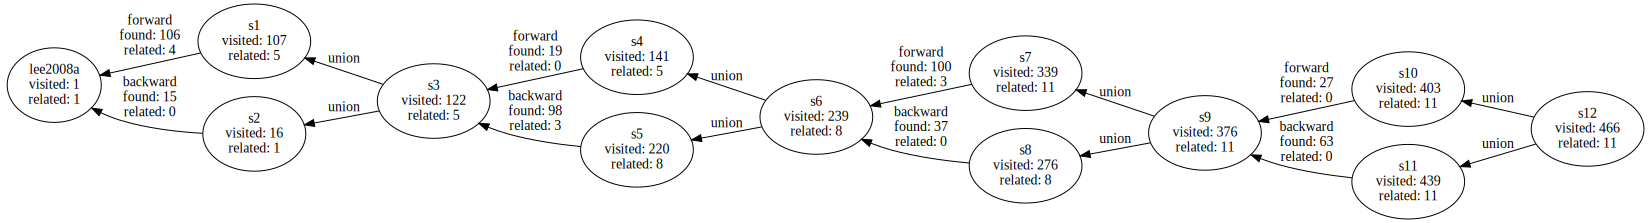

In [118]:
reload()
NAME = "lee2008a"
filter_function = lambda x: x.category in ("snowball", "forward", "backward")
seedset = {work_by_varname(NAME)}
strategy = Strategy(seedset, filter_function)
strategy.initial.name = NAME
state = strategy.sfbu()
state

## Strategy 2 - Database Search + Snowballing (Guideline Wohlin)

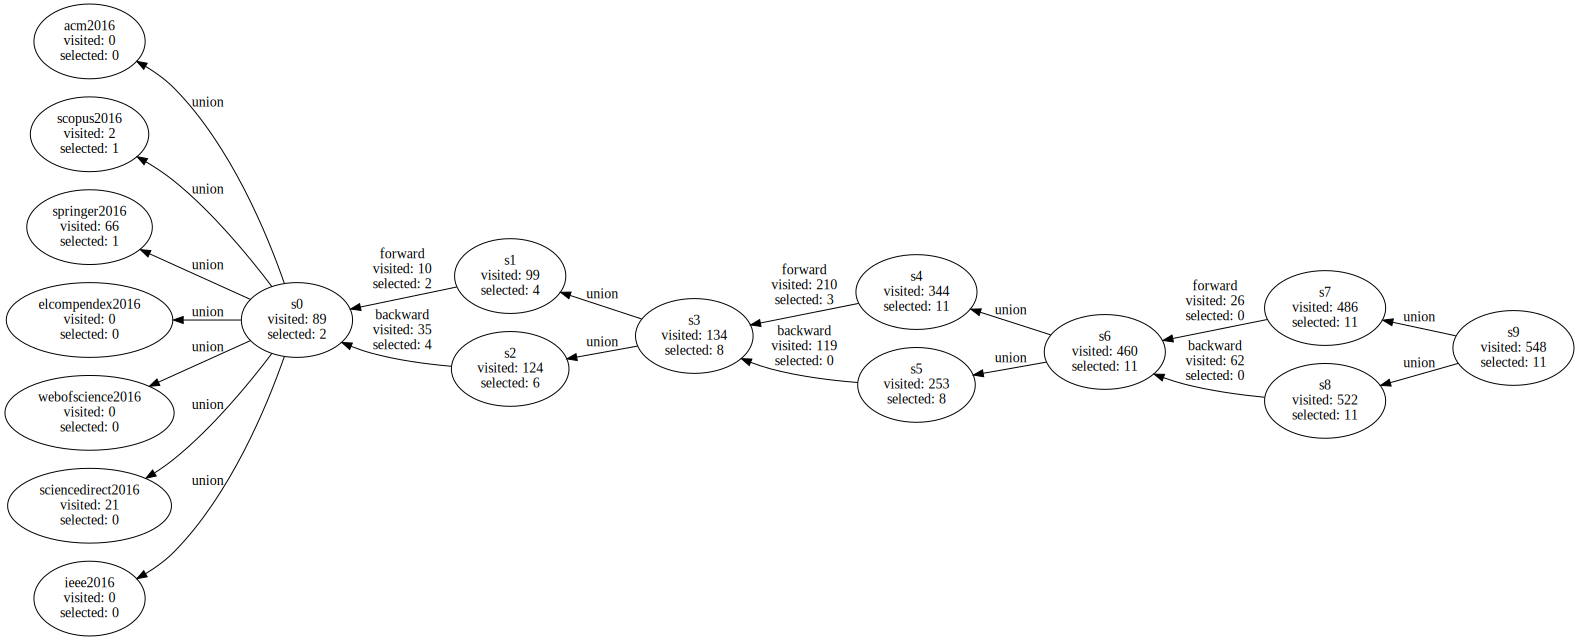

In [119]:
reload()
TOTAL = {x for _, x in load_work_map_all_years() if x.category == "snowball"}
FINAL = {x for _, x in load_work_map_all_years() if getattr(x, "final_selected", 0)}
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = busca_completa(["acm2016", "scopus2016", "springer2016", "elcompendex2016", "webofscience2016", "sciencedirect2016", "ieee2016"], filter_function)
state = strategy.sfbu()

FinalSelection(state)

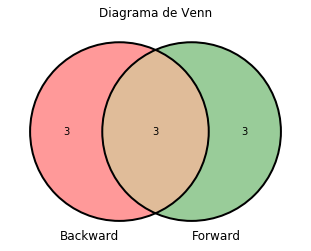

In [120]:
sets = separa_backward_forward(state)
sets = encontraria(strategy, state)
v = venn2(sets, set_labels = ('Backward', 'Forward'))
c = venn2_circles(sets)
plt.title('Diagrama de Venn')
plt.show()

In [121]:
#Backward - Execução de backward em sets[0]
print("Backward", sets[0] @ metakey)
print("Forward", sets[1] @ metakey)

Backward ['soydan2006a', 'grambow2012a', 'lee2008a', 'lee2009a', 'gazel2012a', 'liao2005a']
Forward ['grambow2013a', 'soydan2006a', 'grambow2012a', 'soydan2012a', 'ryu2008a', 'gazel2012a']


In [12]:
name = "E2"
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

d_decimals = 3    
for coluna in ['precision', 'recall', 'fmeasure', 'final_precision', 'final_recall', 'final_fmeasure','delta_related', 'delta_visited', 'delta_selected','related', 'visited', 'final_selected','accumulated_precision', 'accumulated_recall', 'accumulated_fmeasure','final_accumulated_precision', 'final_accumulated_recall', 'final_accumulated_fmeasure']:
      df[coluna] = df[coluna].apply(lambda x: round(x,d_decimals))
        
df

17,state,precision,recall,fmeasure,final_precision,final_recall,final_fmeasure,operation,delta_related,delta_visited,delta_selected,related,visited,final_selected,accumulated_precision,accumulated_recall,accumulated_fmeasure,final_accumulated_precision,final_accumulated_recall,final_accumulated_fmeasure
0,ieee2016,NaN,0.000,0.000,NaN,0.000,0.000,-,0,0,0,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000
1,sciencedirect2016,0.000,0.000,0.000,0.000,0.000,0.000,-,0,21,0,0,21,0,0.000,0.000,0.000,0.000,0.000,0.000
2,webofscience2016,NaN,0.000,0.000,NaN,0.000,0.000,-,0,0,0,0,0,0,0.015,0.000,0.000,0.015,0.000,0.000
3,elcompendex2016,NaN,0.000,0.000,NaN,0.000,0.000,-,0,0,0,0,0,0,0.015,0.000,0.000,0.015,0.000,0.000
4,springer2016,0.015,0.071,0.025,0.000,0.000,0.000,-,1,66,0,1,66,1,0.015,0.071,0.025,0.015,0.071,0.025
5,scopus2016,0.500,0.071,0.125,0.000,0.000,0.000,-,1,2,0,1,2,1,0.500,0.071,0.125,0.500,0.071,0.125
6,acm2016,NaN,0.000,0.000,NaN,0.000,0.000,-,0,0,0,0,0,0,0.022,0.000,0.000,0.022,0.000,0.000
7,s0,NaN,0.000,0.000,NaN,0.000,0.000,union,0,0,0,2,89,2,0.022,0.143,0.039,0.022,0.143,0.039
8,s2,0.114,0.286,0.163,0.114,0.286,0.163,backward,4,35,4,6,124,6,0.048,0.429,0.087,0.048,0.429,0.087
9,s1,0.200,0.143,0.167,0.200,0.143,0.167,forward,2,10,2,4,99,4,0.040,0.286,0.071,0.040,0.286,0.071


In [13]:
ndf

NameError: name 'ndf' is not defined

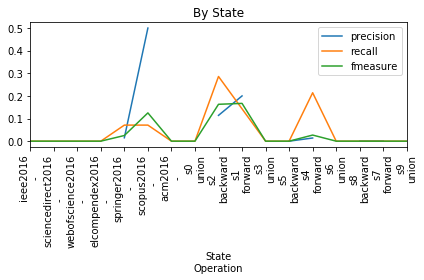

In [14]:
#ndf = df.loc[df['operation'] == 'union'].reset_index(drop=True)
fig = plt.figure()
df['precision'].plot(legend=True)
df['recall'].plot(legend=True)
df['fmeasure'].plot(legend=True)
ax = plt.gca()
ax.set_xticklabels(df["state"] + "\n" + df["operation"])
ax.set_title("By State");
plt.xticks(np.arange(0, len(df), 1.0), rotation='vertical')
plt.xlabel("State\nOperation")
plt.tight_layout()

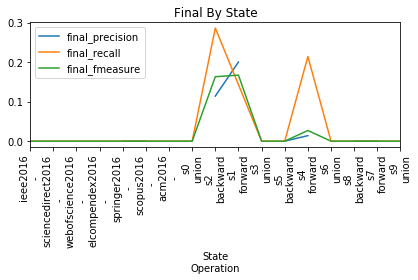

In [15]:
#ndf = df.loc[df['operation'] == 'union'].reset_index(drop=True)
fig = plt.figure()
df['final_precision'].plot(legend=True)
df['final_recall'].plot(legend=True)
df['final_fmeasure'].plot(legend=True)
ax = plt.gca()
ax.set_xticklabels(df["state"] + "\n" + df["operation"])
ax.set_title("Final By State");
plt.xticks(np.arange(0, len(df), 1.0), rotation='vertical')
plt.xlabel("State\nOperation")
plt.tight_layout()

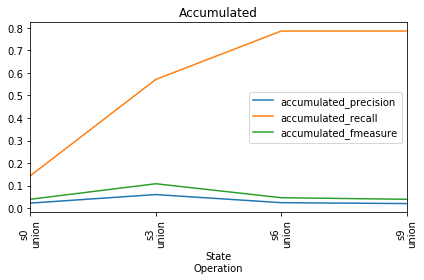

In [16]:
# ---- Grafico de linha para Somente Union 

ndf = df.loc[df['operation'] == 'union'].reset_index(drop=True)
fig = plt.figure()
ndf['accumulated_precision'].plot(legend=True)
ndf['accumulated_recall'].plot(legend=True)
ndf['accumulated_fmeasure'].plot(legend=True)
ax = plt.gca()
ax.set_xticklabels(ndf["state"] + "\n" + ndf["operation"])
plt.xticks(np.arange(0, len(ndf), 1.0), rotation='vertical')
plt.xlabel("State\nOperation")
ax.set_title("Accumulated");
plt.tight_layout()


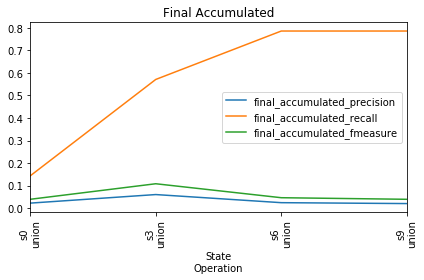

In [17]:
ndf = df.loc[df['operation'] == 'union'].reset_index(drop=True)
fig = plt.figure()
ndf['final_accumulated_precision'].plot(legend=True)
ndf['final_accumulated_recall'].plot(legend=True)
ndf['final_accumulated_fmeasure'].plot(legend=True)
ax = plt.gca()
ax.set_xticklabels(ndf["state"] + "\n" + ndf["operation"])
plt.xticks(np.arange(0, len(ndf), 1.0), rotation='vertical')
plt.xlabel("State\nOperation")
ax.set_title("Final Accumulated");
plt.tight_layout()

## Strategy 3 - Informal Search (Google Scholar) + Snowballing (Guideline Wohlin)

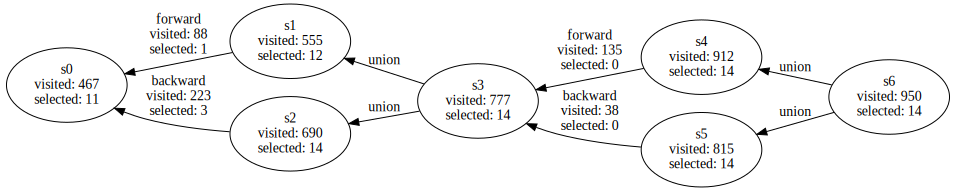

In [19]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("gs2016Informal", filter_function=filter_function))
state = strategy.sfbu()
FinalSelection(state)

In [20]:
name = "E3"
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

d_decimals = 3    
for coluna in ['precision', 'recall', 'fmeasure', 'final_precision', 'final_recall', 'final_fmeasure','delta_related', 'delta_visited', 'delta_selected','related', 'visited', 'final_selected','accumulated_precision', 'accumulated_recall', 'accumulated_fmeasure','final_accumulated_precision', 'final_accumulated_recall', 'final_accumulated_fmeasure']:
      df[coluna] = df[coluna].apply(lambda x: round(x,d_decimals))

df

7,state,precision,recall,fmeasure,final_precision,final_recall,final_fmeasure,operation,delta_related,delta_visited,delta_selected,related,visited,final_selected,accumulated_precision,accumulated_recall,accumulated_fmeasure,final_accumulated_precision,final_accumulated_recall,final_accumulated_fmeasure
0,s0,0.024,0.786,0.046,0.000,0.000,0.000,-,11,467,0,11,467,11,0.024,0.786,0.046,0.024,0.786,0.046
1,s2,0.013,0.214,0.025,0.013,0.214,0.025,backward,3,223,3,14,690,14,0.020,1.000,0.040,0.020,1.000,0.040
2,s1,0.011,0.071,0.020,0.011,0.071,0.020,forward,1,88,1,12,555,12,0.022,0.857,0.042,0.022,0.857,0.042
3,s3,NaN,0.000,0.000,NaN,0.000,0.000,union,0,0,0,14,777,14,0.018,1.000,0.035,0.018,1.000,0.035
4,s5,0.000,0.000,0.000,0.000,0.000,0.000,backward,0,38,0,14,815,14,0.017,1.000,0.034,0.017,1.000,0.034
5,s4,0.000,0.000,0.000,0.000,0.000,0.000,forward,0,135,0,14,912,14,0.015,1.000,0.030,0.015,1.000,0.030
6,s6,NaN,0.000,0.000,NaN,0.000,0.000,union,0,0,0,14,950,14,0.015,1.000,0.029,0.015,1.000,0.029



## Strategy 4 - Scopus + Snowballing (Guideline Wohlin)

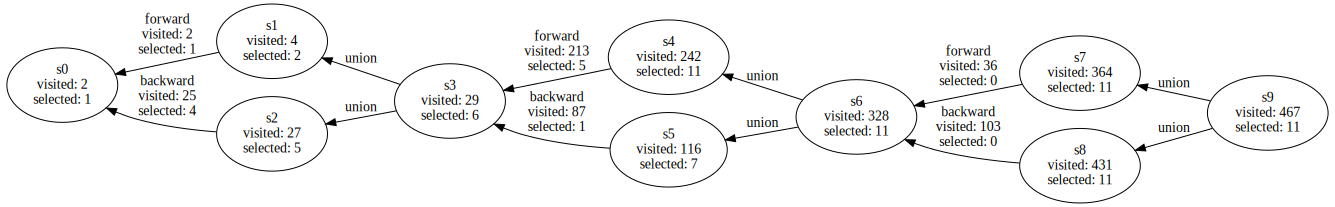

In [22]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus2016", filter_function=filter_function))

state = strategy.sfbu()
FinalSelection(state)

In [23]:
name = "E4"
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

d_decimals = 3    
for coluna in ['precision', 'recall', 'fmeasure', 'final_precision', 'final_recall', 'final_fmeasure','delta_related', 'delta_visited', 'delta_selected','related', 'visited', 'final_selected','accumulated_precision', 'accumulated_recall', 'accumulated_fmeasure','final_accumulated_precision', 'final_accumulated_recall', 'final_accumulated_fmeasure']:
      df[coluna] = df[coluna].apply(lambda x: round(x,d_decimals))

df

10,state,precision,recall,fmeasure,final_precision,final_recall,final_fmeasure,operation,delta_related,delta_visited,delta_selected,related,visited,final_selected,accumulated_precision,accumulated_recall,accumulated_fmeasure,final_accumulated_precision,final_accumulated_recall,final_accumulated_fmeasure
0,s0,0.500,0.071,0.125,0.000,0.000,0.000,-,1,2,0,1,2,1,0.500,0.071,0.125,0.500,0.071,0.125
1,s2,0.160,0.286,0.205,0.160,0.286,0.205,backward,4,25,4,5,27,5,0.185,0.357,0.244,0.185,0.357,0.244
2,s1,0.500,0.071,0.125,0.500,0.071,0.125,forward,1,2,1,2,4,2,0.500,0.143,0.222,0.500,0.143,0.222
3,s3,NaN,0.000,0.000,NaN,0.000,0.000,union,0,0,0,6,29,6,0.207,0.429,0.279,0.207,0.429,0.279
4,s5,0.011,0.071,0.020,0.011,0.071,0.020,backward,1,87,1,7,116,7,0.060,0.500,0.108,0.060,0.500,0.108
5,s4,0.023,0.357,0.044,0.023,0.357,0.044,forward,5,213,5,11,242,11,0.045,0.786,0.086,0.045,0.786,0.086
6,s6,NaN,0.000,0.000,NaN,0.000,0.000,union,0,0,0,11,328,11,0.034,0.786,0.064,0.034,0.786,0.064
7,s8,0.000,0.000,0.000,0.000,0.000,0.000,backward,0,103,0,11,431,11,0.026,0.786,0.049,0.026,0.786,0.049
8,s7,0.000,0.000,0.000,0.000,0.000,0.000,forward,0,36,0,11,364,11,0.030,0.786,0.058,0.030,0.786,0.058
9,s9,NaN,0.000,0.000,NaN,0.000,0.000,union,0,0,0,11,467,11,0.024,0.786,0.046,0.024,0.786,0.046


## Strategy 5 - Scopus + Snowballing (Short Paper)

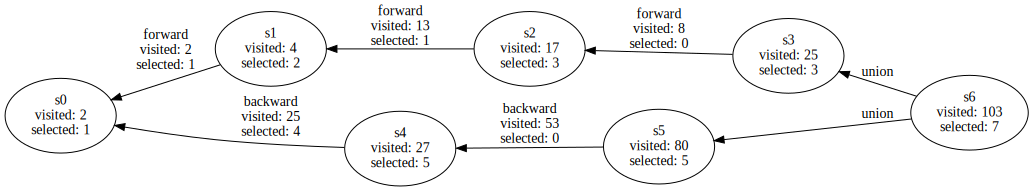

In [24]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus2016", filter_function=filter_function))
state = strategy.s2bbff2u()
FinalSelection(state)

In [25]:
name = "E5"
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

d_decimals = 3    
for coluna in ['precision', 'recall', 'fmeasure', 'final_precision', 'final_recall', 'final_fmeasure','delta_related', 'delta_visited', 'delta_selected','related', 'visited', 'final_selected','accumulated_precision', 'accumulated_recall', 'accumulated_fmeasure','final_accumulated_precision', 'final_accumulated_recall', 'final_accumulated_fmeasure']:
      df[coluna] = df[coluna].apply(lambda x: round(x,d_decimals))

df

7,state,precision,recall,fmeasure,final_precision,final_recall,final_fmeasure,operation,delta_related,delta_visited,delta_selected,related,visited,final_selected,accumulated_precision,accumulated_recall,accumulated_fmeasure,final_accumulated_precision,final_accumulated_recall,final_accumulated_fmeasure
0,s0,0.500,0.071,0.125,0.000,0.000,0.000,-,1,2,0,1,2,1,0.500,0.071,0.125,0.500,0.071,0.125
1,s1,0.500,0.071,0.125,0.500,0.071,0.125,forward,1,2,1,2,4,2,0.500,0.143,0.222,0.500,0.143,0.222
2,s4,0.160,0.286,0.205,0.160,0.286,0.205,backward,4,25,4,5,27,5,0.185,0.357,0.244,0.185,0.357,0.244
3,s2,0.077,0.071,0.074,0.077,0.071,0.074,forward,1,13,1,3,17,3,0.176,0.214,0.194,0.176,0.214,0.194
4,s5,0.000,0.000,0.000,0.000,0.000,0.000,backward,0,53,0,5,80,5,0.062,0.357,0.106,0.062,0.357,0.106
5,s3,0.000,0.000,0.000,0.000,0.000,0.000,forward,0,8,0,3,25,3,0.120,0.214,0.154,0.120,0.214,0.154
6,s6,NaN,0.000,0.000,NaN,0.000,0.000,union,0,0,0,7,103,7,0.068,0.500,0.120,0.068,0.500,0.120


## Strategy 6 - Scopus + Snowballing (JF BF)

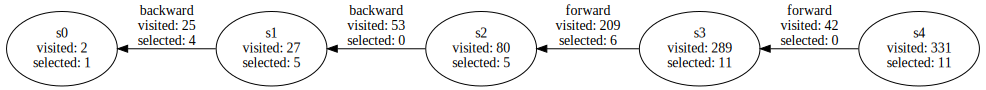

In [27]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus2016", filter_function=filter_function))
state = strategy.bbff()
FinalSelection(state)

In [28]:
name = "E6"
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

d_decimals = 3    
for coluna in ['precision', 'recall', 'fmeasure', 'final_precision', 'final_recall', 'final_fmeasure','delta_related', 'delta_visited', 'delta_selected','related', 'visited', 'final_selected','accumulated_precision', 'accumulated_recall', 'accumulated_fmeasure','final_accumulated_precision', 'final_accumulated_recall', 'final_accumulated_fmeasure']:
      df[coluna] = df[coluna].apply(lambda x: round(x,d_decimals))

df

5,state,precision,recall,fmeasure,final_precision,final_recall,final_fmeasure,operation,delta_related,delta_visited,delta_selected,related,visited,final_selected,accumulated_precision,accumulated_recall,accumulated_fmeasure,final_accumulated_precision,final_accumulated_recall,final_accumulated_fmeasure
0,s0,0.500,0.071,0.125,0.000,0.000,0.000,-,1,2,0,1,2,1,0.500,0.071,0.125,0.500,0.071,0.125
1,s1,0.160,0.286,0.205,0.160,0.286,0.205,backward,4,25,4,5,27,5,0.185,0.357,0.244,0.185,0.357,0.244
2,s2,0.000,0.000,0.000,0.000,0.000,0.000,backward,0,53,0,5,80,5,0.062,0.357,0.106,0.062,0.357,0.106
3,s3,0.029,0.429,0.054,0.029,0.429,0.054,forward,6,209,6,11,289,11,0.038,0.786,0.073,0.038,0.786,0.073
4,s4,0.000,0.000,0.000,0.000,0.000,0.000,forward,0,42,0,11,331,11,0.033,0.786,0.064,0.033,0.786,0.064


## Strategy 7 - Scopus + Snowballing (JF FB)

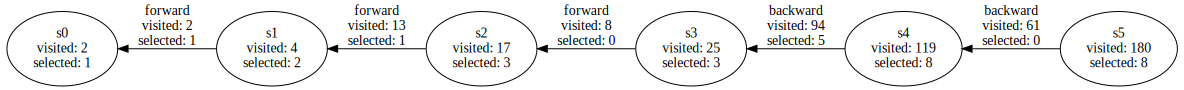

In [31]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus2016", filter_function=filter_function))
state = strategy.ffbb()
FinalSelection(state)

In [32]:
name = "E7"
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

d_decimals = 3    
for coluna in ['precision', 'recall', 'fmeasure', 'final_precision', 'final_recall', 'final_fmeasure','delta_related', 'delta_visited', 'delta_selected','related', 'visited', 'final_selected','accumulated_precision', 'accumulated_recall', 'accumulated_fmeasure','final_accumulated_precision', 'final_accumulated_recall', 'final_accumulated_fmeasure']:
      df[coluna] = df[coluna].apply(lambda x: round(x,d_decimals))

df

6,state,precision,recall,fmeasure,final_precision,final_recall,final_fmeasure,operation,delta_related,delta_visited,delta_selected,related,visited,final_selected,accumulated_precision,accumulated_recall,accumulated_fmeasure,final_accumulated_precision,final_accumulated_recall,final_accumulated_fmeasure
0,s0,0.500,0.071,0.125,0.000,0.000,0.000,-,1,2,0,1,2,1,0.500,0.071,0.125,0.500,0.071,0.125
1,s1,0.500,0.071,0.125,0.500,0.071,0.125,forward,1,2,1,2,4,2,0.500,0.143,0.222,0.500,0.143,0.222
2,s2,0.077,0.071,0.074,0.077,0.071,0.074,forward,1,13,1,3,17,3,0.176,0.214,0.194,0.176,0.214,0.194
3,s3,0.000,0.000,0.000,0.000,0.000,0.000,forward,0,8,0,3,25,3,0.120,0.214,0.154,0.120,0.214,0.154
4,s4,0.053,0.357,0.093,0.053,0.357,0.093,backward,5,94,5,8,119,8,0.067,0.571,0.120,0.067,0.571,0.120
5,s5,0.000,0.000,0.000,0.000,0.000,0.000,backward,0,61,0,8,180,8,0.044,0.571,0.082,0.044,0.571,0.082


# Analyses

In [33]:
%matplotlib inline
import pandas as pd

In [34]:
df = pd.DataFrame (array,columns = [
    'Estratégia', 'Related', 'Visited', 'Final Selected', 
    'Precision', 'Recall', 'F-Measure',
    'Final Precision', 'Final Recall', 'Final F-Measure'])
df.index = df['Estratégia']
df
print (array)

d_decimals = 2    
for coluna in ['Precision', 'Recall', 'F-Measure', 'Final Precision', 'Final Recall', 'Final F-Measure',]:
      df[coluna] = df[coluna].apply(lambda x: round(x,d_decimals))

df

[['E1', 11, 482, 11, 0.022821576763485476, 1.0, 0.04462474645030426, 0.022821576763485476, 0.7857142857142857, 0.044354838709677415], ['E2', 11, 548, 11, 0.020072992700729927, 0.7857142857142857, 0.03914590747330961, 0.020072992700729927, 0.7857142857142857, 0.03914590747330961], ['E3', 14, 950, 14, 0.014736842105263158, 1.0, 0.02904564315352697, 0.014736842105263158, 1.0, 0.02904564315352697], ['E4', 11, 467, 11, 0.023554603854389723, 0.7857142857142857, 0.04573804573804574, 0.023554603854389723, 0.7857142857142857, 0.04573804573804574], ['E5', 7, 103, 7, 0.06796116504854369, 0.5, 0.11965811965811965, 0.06796116504854369, 0.5, 0.11965811965811965], ['E6', 11, 331, 11, 0.03323262839879154, 0.7857142857142857, 0.06376811594202898, 0.03323262839879154, 0.7857142857142857, 0.06376811594202898], ['E7', 8, 180, 8, 0.044444444444444446, 0.5714285714285714, 0.08247422680412371, 0.044444444444444446, 0.5714285714285714, 0.08247422680412371]]


,Estratégia,Related,Visited,Final Selected,Precision,Recall,F-Measure,Final Precision,Final Recall,Final F-Measure
Estratégia,,,,,,,,,,
E1,E1,11,482,11,0.02,1.00,0.04,0.02,0.79,0.04
E2,E2,11,548,11,0.02,0.79,0.04,0.02,0.79,0.04
E3,E3,14,950,14,0.01,1.00,0.03,0.01,1.00,0.03
E4,E4,11,467,11,0.02,0.79,0.05,0.02,0.79,0.05
E5,E5,7,103,7,0.07,0.50,0.12,0.07,0.50,0.12
E6,E6,11,331,11,0.03,0.79,0.06,0.03,0.79,0.06
E7,E7,8,180,8,0.04,0.57,0.08,0.04,0.57,0.08


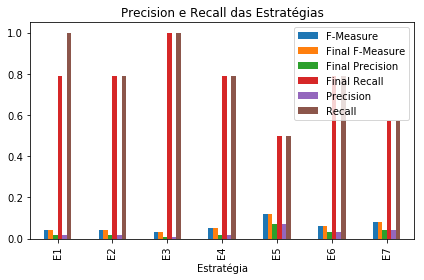

In [35]:
import matplotlib.pyplot as plt
exclude = ['Related', 'Visited', 'Final Selected']

ax = df.loc[:, df.columns.difference(exclude)].plot.bar(title ="Precision e Recall das Estratégias")
plt.tight_layout()


In [36]:
df

d_decimals = 2    
for coluna in ['Precision', 'Recall', 'F-Measure', 'Final Precision', 'Final Recall', 'Final F-Measure',]:
      df[coluna] = df[coluna].apply(lambda x: round(x,d_decimals))

df

,Estratégia,Related,Visited,Final Selected,Precision,Recall,F-Measure,Final Precision,Final Recall,Final F-Measure
Estratégia,,,,,,,,,,
E1,E1,11,482,11,0.02,1.00,0.04,0.02,0.79,0.04
E2,E2,11,548,11,0.02,0.79,0.04,0.02,0.79,0.04
E3,E3,14,950,14,0.01,1.00,0.03,0.01,1.00,0.03
E4,E4,11,467,11,0.02,0.79,0.05,0.02,0.79,0.05
E5,E5,7,103,7,0.07,0.50,0.12,0.07,0.50,0.12
E6,E6,11,331,11,0.03,0.79,0.06,0.03,0.79,0.06
E7,E7,8,180,8,0.04,0.57,0.08,0.04,0.57,0.08


In [37]:
#df.to_csv("estrategias.csv")
df.to_excel("estrategias.xlsx")

In [ ]:
#len ({x for _, x in load_work_map_all_years() if x.category == "snowball"})

In [ ]:
#{x for _, x in load_work_map_all_years() if x.category == "snowball"} @ metakey_title